<a href="https://colab.research.google.com/github/Beh-noush/TT-classification/blob/main/TT_classification_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import torch
import torch.nn as nn
import math
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
torch.manual_seed(0)

torch.cuda.is_available()

if torch.cuda.is_available:
  dev = 'cuda:0'
else:
  dev = 'CPU'

device = torch.device(dev)

from tqdm import tqdm
!pip install tensorly
import tensorly as tl
tl.set_backend('pytorch')

     |████████████████████████████████| 163kB 28.1MB/s 
     |████████████████████████████████| 163kB 41.0MB/s 


In [ ]:
def inner_product(data_tensor, weight_tensor):
  """
  Computes the inner products of between a batch of tensors and a TT tensor

  Parameters
  -------
  data_tensor: torch tensor
               batch of input tensors of size n x d_1 x ... x d_p
  weight_tensor: list
               list of length p containing the cores of the TT tensor

  Returns
  ------
  vector
    Vector of size n containing the inner products 
  """
  W = tl.tt_to_tensor(weight_tensor)
  return torch.matmul(data_tensor.reshape([data_tensor.shape[0],-1]),W.ravel())

In [ ]:
class TTModel(nn.Module):      
    """ 
    Class for a linear binary classifier parameterized by a TT tensor 
    """
    def __init__(self, order, dimension, rank, init='normal'): 
        """
        Parameters
        ---------
        order: int
          Order of the TT tensor
        dimension: int
          Uniform dimension of the the TT tensor 
        rank: int
          Uniform rank of the the TT tensor
        init: string
          initialization method for the core tensors of the TT parameters
          choices are "uniform" and "normal"
        """
        super().__init__()
        self.order, self.dim, self.bond = order, dimension, rank

        cores = [None for i in range(self.order)]
        self.weights = [None for i in range(self.order)]
        cores[0] = torch.Tensor(1,self.dim, self.bond)
        for l in range(1,self.order-1):
          cores[l] = torch.Tensor(self.bond, self.dim, self.bond)
        cores[-1] = torch.Tensor(self.bond, self.dim,1)
        for l in range(self.order):
          self.weights[l] = nn.Parameter(cores[l])
        self.params = nn.ParameterList(self.weights)

        # initialize weights and biases
        for weight in self.params:
          if init=='normal':
            torch.nn.init.normal_( weight, mean=0.0, std= .5)
          elif init=='uniform':
            torch.nn.init.uniform_(weight,-1,1)

    def forward(self, x): 
        """
        Computes the forward pass

        Parameters
        ---------
        self

        x: Batches of n input tensors of order [order]
            
        Returns
        ------
        torch tensor of shape [n,2]
          Tensor containing the scores of each input for the two classes
    
        """
        prod = inner_product(x, self.weights)
        return torch.stack((prod,-1*prod),0).T  # w times x + b       



In [ ]:
def train_TT_model(training_data, rank, loss, optimizer, lr, epochs):
  """
  Trains a TT classifier and returns the trained model.

  Parameters
  --------
  training_data: tuple of two tensors, inputs (size n x d_1 x ... x d_p) and 
                 labels (size n vector of 0s and 1s)
  rank: int
        the model's rank
  loss: 
        loss function.
  optimizer:
        pytorch optimizer 
  lr: float
        learning rate
  epochs: int
        number of learning epochs

  Returns
  ------
  TTModel
    Trained model
      
  """
  inputs = training_data[0]
  labels_train = training_data[1]
  dimension = inputs.shape[1]
  order = len(inputs.shape) - 1
  model = TTModel(order, dimension, rank)#.to(device)
  optimizer = optimizer(model.parameters(), lr)
  for e in range(epochs):           
    result = model(inputs)#.to(device)                                    
    #pred = torch.argmax(result, axis = 1)
    loss_train = loss(result, labels_train)
    loss_train.backward()
    optimizer.step()
    optimizer.zero_grad()
  return model


# First Experiment: Different Sample Sizes 

In [ ]:
dimension = 4
order = 4
target_rank = 8
test_size = 4000
n_runs = 20
train_sample_sizes = [100,200,400,800,1400,2000,3000]  
ranks = [2,4]
learning_rate = 0.01
epochs = 1000
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD
# generate target model and test data
target_model = TTModel(order,dimension,target_rank,init='uniform')
test_inputs = torch.randn([test_size] + [dimension]*order)
test_labels = torch.argmax(target_model.forward(test_inputs),axis=1)



results = []

for n in tqdm(range(n_runs),position=0, leave=True):
  result = {}
  for rank in ranks:
    result[rank] = []
    for size in train_sample_sizes:
      # generate training data
      inputs = torch.randn([size]+[dimension]*order )
      labels = torch.argmax(target_model.forward(inputs),axis=1)

      # train the model
      model = train_TT_model((inputs, labels), rank, loss, optimizer, lr=learning_rate, epochs=epochs)
      test_loss = loss(model.forward(test_inputs), test_labels)
      train_loss = loss(model.forward(inputs), labels)
      result[rank].append((size,train_loss,test_loss))
  results.append(result)              
                                        

100%|██████████| 20/20 [03:19<00:00,  9.98s/it]


### Plotting the results

[0.7026426  0.1959885  0.07610572 0.03401656 0.0130482  0.00936842
 0.00555066]
[3.4085011  0.699389   0.2122777  0.08208586 0.03694681 0.02745454
 0.01571509]


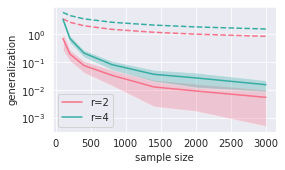

In [ ]:
log_gen_gaps = {}
upper_bound = {}
with sns.axes_style('darkgrid'):
  colors = sns.color_palette('husl' , 2)
  figure = plt.figure(figsize=(4,2.3))
  c = 0
  for rank in ranks:
    log_gen_gaps[rank] = np.array([[((losses[2]-losses[1]).detach()) for losses in result[rank]] for result in results])
    #upper_bound[rank] = np.array( [(np.sqrt(order*dimension*rank**2 *math.log(sample_size)/sample_size))  for sample_size in train_sample_sizes])
    n_params = order*dimension*rank**2
    upper_bound[rank] = np.array( [2*(np.sqrt( n_params*math.log(8*sample_size*order*np.e / n_params)/sample_size))  for sample_size in train_sample_sizes])
    ys = np.mean(log_gen_gaps[rank], axis = 0) #maybe add axis=1
    stds = np.std(log_gen_gaps[rank], axis = 0)
    print(ys)
    plt.xlabel('sample size')
    plt.ylabel('generalization')
    plt.yscale('log')
    plt.plot(train_sample_sizes, ys, color = colors[c]  , label ='experiment')
    plt.fill_between(train_sample_sizes, list(torch.tensor(ys) - torch.tensor(stds)) , list(torch.tensor(ys) + torch.tensor(stds)), alpha = .3, facecolor = colors[c], label='_nolegend_')
    plt.plot(train_sample_sizes,list(torch.tensor(upper_bound[rank])), color = colors[c] , linestyle ='dashed', label='_nolegend_') # The factor 1/4 is to reduce the distance between the bound curve from the theory and the one from our experiment.
    c+=1
  plt.legend("r=2 r=4".split())

# Second Experiment: Different Ranks  

In [ ]:
dimension = 4
order = 4
target_rank = 8
test_size = 4000
n_runs = 20
train_sample_sizes = [2000, 4000]
ranks = [2, 4, 6 , 8 , 10, 12, 14]
learning_rate = 0.01
epochs = 1000
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD

target_model = TTModel(order,dimension,target_rank,init='uniform')
test_inputs = torch.randn([test_size] + [dimension]*order)
test_labels = torch.argmax(target_model.forward(test_inputs),axis=1)


results = []
for n in range(n_runs):
  result = {}
  for sample_size in train_sample_sizes:
    result[sample_size] = []
    for rank in ranks:
      # generate training data
      inputs = torch.randn([sample_size] + [dimension]*order)
      labels = torch.argmax(target_model.forward(inputs), axis = 1)
      # train the model
      model = train_TT_model((inputs, labels), rank, loss, optimizer, lr=learning_rate, epochs=epochs)
      test_loss = loss(model.forward(test_inputs), test_labels)
      train_loss = loss(model.forward(inputs), labels)
      result[sample_size].append((sample_size,train_loss,test_loss))
  results.append(result)        

  

### Plotting the results

[0.00640478 0.02303103 0.03646769 0.05027365 0.07151561 0.08757969
 0.10857521]
[0.00557374 0.01454905 0.01445679 0.02332144 0.02879337 0.03536797
 0.03862754]


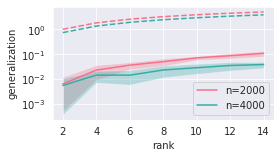

In [ ]:
log_gen_gaps = {}
upper_bound = {}
with sns.axes_style('darkgrid'):
  colors = sns.color_palette('husl' , 2)
  figure = plt.figure(figsize=(4,2.3))
  c = 0
  for sample_size in train_sample_sizes:
    log_gen_gaps[sample_size] = np.array([[((losses[2]-losses[1]).detach()) for losses in result[sample_size]] for result in results])
    n_params = order*dimension
    upper_bound[sample_size] = np.array( [2*(np.sqrt( n_params*rank**2*math.log(8*sample_size*order*np.e / (n_params*rank**2))/sample_size))  for rank in ranks])
    ys = np.mean(log_gen_gaps[sample_size], axis = 0) 
    stds = np.std(log_gen_gaps[sample_size], axis = 0)
    print(ys)
    plt.xlabel('rank')
    plt.ylabel('generalization')
    plt.yscale('log')
    plt.plot(ranks, ys, color = colors[c]  , label ='experiment')
    plt.fill_between(ranks, list(torch.tensor(ys) - torch.tensor(stds)) , list(torch.tensor(ys) + torch.tensor(stds)), alpha = .3, facecolor = colors[c], label='_nolegend_')
    plt.plot(ranks,list(torch.tensor(upper_bound[sample_size])), color = colors[c] , linestyle ='dashed', label='_nolegend_') # The factor 1/4 is to reduce the distance between the bound curve from the theory and the one from our experiment.
    c+=1
    plt.tight_layout()

  plt.legend("n=2000 n=4000".split())